# Bayesian Modeling and Markov Chain Monte Carlo

### Data Science 520

## Overview

In a previous lesson we explored the basics of Bayesian parameter estimation. The methods we used are restricted to only simple models. This lesson introduces you to a general and flexible form of Bayesian modeling using the **Markov chain Monte Carlo (MCMC)** methods. MCMC methods can be extended to extremely complex models, including **Bayesian hierarchical models**.  

![](../images/Flips.png)
<center>Source explain xkcd</center>


## Software

Most Bayesian software packages use efficient Markov chain Monte Carlo (MCMC) methods. The most widely used of these is [Stan](https://mc-stan.org/), named for mathematician Stanislaw Ulam. Stan also includes variational approximation methods. 

A powerful, and generally more user friendly, Python package is [PyMC3](https://docs.pymc.io/). We will use PyMC3 in this lesson. The documentation for PyMC3 includes an excellent [Getting Started Jupyter Notebook](https://docs.pymc.io/notebooks/getting_started.html) along with other tutorials. Additionally you can find a number of [example Jupyter notebooks](https://docs.pymc.io/nb_examples/index.html) for many application areas.  

***
**Note:** To run this notebook you must have installed [PyMC3](https://docs.pymc.io/notebooks/getting_started.html).
***

## Review of Bayes Theorem

Recall Bayes theorem:

$$P(A|B) = \frac{P(A)P(B|A)}{P(B)}$$

Computing the normalization $P(B)$ is a bit of a mess. But fortunately, we don't always need the denominator. We can rewrite Bayes Theorem as:

$$𝑃(𝐴│𝐵)=𝑘∙𝑃(𝐵|𝐴)𝑃(𝐴)$$

Ignoring the normalizaton constant $k$, we get:

$$𝑃(𝐴│𝐵) \propto 𝑃(𝐵|𝐴)𝑃(𝐴)$$

### Bayesian parameter estimation

How to we interpret the relationships shown above? We do this as follows:

$$Posterior\ Distribution \propto Likelihood \bullet Prior\ Distribution \\
Or\\
𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠│𝑑𝑎𝑡𝑎) \propto 𝑃(𝑑𝑎𝑡𝑎|𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠)𝑃(𝑝𝑎𝑟𝑎𝑚𝑒𝑡𝑒𝑟𝑠) $$

These relationships apply to the observed data distributions, or to parameters in a model (partial slopes, intercept, error distributions, lasso constant,…). 

## Grid Sampling and Scalability

Real-world Bayes models have large numbers of parameters, even into the millions. As a naive approach to Bayesian analysis would be to simply grid sample across the dimensions of the parameter space. However, grid sampling will not scale. To understand the scaling problem, do the following thought experiment, where each dimension is sampled 100 times:

- For a 1-parameter model: $100$ samples.
- For a 2-parameter model: $100^2 = 10000$ samples.
- For a 3-parameter model: $100^3 = 10^5$ samples.
- For a 100-parameter model: $100^{100} = 10^{102}$ samples. 

As you can see, the computational complexity of grid sampling has **exponential scaling** with dimensionality. Clearly, we need a better approach. 

## Introduction to Markov Chain Monte Carlo

Large-scale Bayesian models use a family of efficient sampling methods known as **Markov chain Monte Carlo sampling**. Rather that systematically sampling on a grid MCMC methods sample distributions randomly. While MCMC methods are computationally efficient, but requires effort to understand how it works and what to do when things go wrong. 

In [1]:
##!pip install pymc3
import pymc3

import pandas as pd
import numpy as np
import numpy.random as nr
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### What is a Markov process?

As you might guess from the name, a MCMC sampling uses a chain of **Markov sampling processes**. A Markov process is a **stochastic process** that a makes transition from a current state, $x_t$, to some next state, $x_{t+1}$, with some probability $\Pi$. A Markov process has **no dependency on past states**. We can summarize properties of a Markov process:   
- The probability of transition from one state to another is parameterized by a matrix of probabilities, $\Pi$, of dim N X N for N possible state transitions,  
- $\Pi$  only depends on the current state, $x_t$,     
- The transition can be to current state.   

Since a Markov transition process depends only on the current state and not the history, we say a Markov process is **memoryless**. We can express the sequence of a Markov transition processes as:

$$P(X_{t + 1}| X_t = x_t, x_{t-1}, x_{t-2}, \ldots, x_0) = p(X_{t + 1}| x_t)$$

Notice that, since the Markov process is memoryless, the transition probability only depends on the current state, $x_t$. There is no dependency on any previous states, $\{x_{t-1}, x_{t-2}, \ldots, x_0 \}$. 

For a system with $N$ possible states we can write the **transition probability matrix**, $\Pi$, from one state to another as follows:

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \cdots & \pi_{1, N}\\
\pi_{2,1} & \pi_{2,2} & \cdots & \pi_{2,N}\\
\cdots & \cdots & \cdots & \cdots \\
\pi_{N,i} & \pi_{N,2} & \cdots & \pi_{N,N}
\end{bmatrix}\\
where\\
\pi_{i,j} = probability\ of\ transition\ to\ state\ i\ from\ state\ j\\
and\\
\pi_{i,i} = probability\ of\ staying\ in\ state\ i\\
further\\
\pi_{i,j} \ne \pi_{j,i}\ in\ general
$$

Notice that the probability of transition does not depend on the previous state history.

### Example of a Markov Process

To make the foregoing more concrete let's construct a simple example. We will start with a system of 3 states, $\{ x_1, x_2, x_3 \}$. The transition matrix is:    

$$\Pi = 
\begin{bmatrix}
\pi_{1,1} & \pi_{1,2} & \pi_{1,3}\\
\pi_{2,1} & \pi_{2,2} & \pi_{2,3}\\
\pi_{3,1} & \pi_{3,2} & \pi_{3,3}
\end{bmatrix}
= 
\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.0 & 0.3 & 0.7\\
0.5 & 0.5 & 0.0
\end{bmatrix}
$$

There are some key points to notice in this transition probability matrix.   
- The probabilities of transition from a state is given in each column. Necessarily, the probabilities in each column must add to 1.0.  
- The probabilities of a transition to the same state are given along the diagonal of the matrix.   
- Some transitions are not possible. These transitions have a probability of 0.0.    

Let's apply this probability matrix to a set of three possible states. As an example, let the **state vector** represent being in the first state at time step $t$; $\vec{x_t} = [1,0,0]$. After a state transition, we compute the probability of being in each of the three possible states at the next time step, $t+1$, as:  

$$\vec{x}_{t+1}  = \Pi\ \vec{x}_t = 
\begin{bmatrix}
0.5 & 0.2 & 0.3\\
0.0 & 0.3 & 0.7\\
0.5 & 0.5 & 0.0
\end{bmatrix} 
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix} =
\begin{bmatrix}
0.5 \\
0.0 \\
0.5 
\end{bmatrix} 
$$


> **Exercise 29-1:**  Based on the transition probability matrix above, answer the following questions:   
> 1. Which state cannot transition to the same state? 
> 2. What is the minimum number of state transitions required to transition from the second state (second column) to the first state (first column)? 

### From Markov process to Markov chain    

So far, we have only discussed a single step Markov process. That is, the process for a single state transition. What happens when there is a series of transitions? A sequence of such transitions is known as a **Markov chain**. There are two major behaviors observed with Markov Chains:  
1. **Episodic Markov chains** have a **terminal state**. The terminal state can only transition to itself. Once the system is in the terminal state, we say that the episode has ended. Episodic processes are not of direct interest here, and we will not pursue them further.   
2. **Continuous Markov chains** have no terminal state and continue indefinitely, at least in principle. Continuous Markov chains sample probability distribution, and are ideal for estimating Bayesian posterior distributions.  

As already indicated, a Markov chain comprises a number of state transitions, one after another. Consider a chain of $n$ state transitions, $\{t_1, t_2, t_3, \ldots, t_n \}$. Each transition in this process has the probabilities given by the state transition matrix, $\Pi$.            

To estimate the probabilities of being in the states we use a special case known as a **stationary Markov chain**. We will not discuss the technical mathematical details here. Here we will just summarize the key result: Over a large number of time steps, the number of times the states are visited is proportional to the state probabilities. Starting with some initial state, $\vec{x}_0$, we can write the relationship as a continuous Markov chain:   

$$\Pi\ \Pi\ \Pi\ \ldots \Pi\ \vec{x}_t = \Pi^n\ \vec{x}_t  \xrightarrow[\text{$n \rightarrow \infty$}]{} \vec{p(x)}$$    

Notice that in the above, we can find the probabilities of the states without ever actually knowing the values of the transition matrix, $\Pi$. As long as we can repeatedly sample the stochastic Markov process, we can estimate the state probabilities. This is the key concept of Markov Chain Monte Carlo sampling. 

As we proceed with this lesson we will use stationary Markov chains to estimate posterior probabilities of Bayesian models. The method relies on the result that the state probabilities converge eventually. As a consequence, we can develop flexible methods for sampling posterior distributions using Markov chain Monte Carlo. In summary, the model is sampled using a Markov chain and the sampled distribution should converge to the posterior distribution.    

A example below will illustrate the convergence of a Markov chain to the steady state probabilities.  

(10, 3)


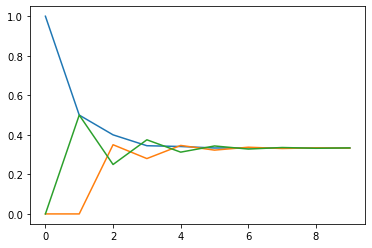

In [4]:
## Create array to hold history of state probabilities
## and initialize a first state, or first row
n=10
state_probabilities = np.zeros((n,3))
state_probabilities[0,:] = [1.0, 0.0, 0.0]

## The transision probability matrix
transision_matrix = np.array([[0.5, 0.2, 0.3],
                            [0.0, 0.3, 0.7],
                            [0.5, 0.5, 0.0]])

for i in range(1,n):
    state_probabilities[i,:] = np.dot(transision_matrix, state_probabilities[i-1,:])
    
print(state_probabilities.shape)    
    
ax=sns.lineplot(x=np.array(range(n)), y=state_probabilities[:,0])   
_=sns.lineplot(x=range(n), y=state_probabilities[:,1], ax=ax)   
_=sns.lineplot(x=range(n), y=state_probabilities[:,2], ax=ax)   

**********************************
> **Exercise 29-2:** Based on the foregoing, answer the following questions:     
> 1. Explain how a Markov chain is constructed from a series of Markov transition processes.    
> 2. After a large number of transitions, the number of times some state have been visited is shown below. Compute the probabilities of each of the states:    

In [5]:
number_of_visits = np.array([200, 1000, 7000, 13000])

## Include code to compute the probabilities below:


## MCMC and the Metropolis-Hastings Algorithm

Using the principle of Markov chains, a number of MCMC algorithms have been developed over time to sample posterior distributions of Bayesian models. The first MCMC sampling algorithm developed is the **Metropolis-Hastings (M-H) algorithm** (Metropolis et al. (1953), Hastings (1970)). This algorithm is often referred to as simply the Metropolis algorithm or the M-H algorithm. 

The M-H algorithm has the following steps to estimate the posterior density of the parameters:
1. Pick a starting point in the parameter space. This choice is typically a bit arbitrary. 
2. Evaluate the posterior distribution according to the model. In other words, take a sample of the likelihood $P(data|parameters)$ and prior, $P(parameters)$, and then compute the posterior.
3. Choose a nearby point in parameter space randomly and evaluate the posterior at this point. The new point in parameter space is selected randomly, using a sampling distribution. The Normal distribution is a common choice of sampling distributions. Other distribution have also been used. 
4. Use the following **decision rule to accept or reject** the new sample:
  - If the likelihood, $p(data | parameters)$, of the new point is greater than your current point, accept new point and move there.
  - If the likelihood of the new point is less than your current point, only accept with probability according to the ratio:  
$$Acceptance\ probability\ = \frac{p(data | new\ parameters)}{p(data | previous\ parameters)}$$.
4. If the sample is accepted, compute the posterior density at the new sample point.
5. Repeat steps 3, 4 and 5 many times.

Eventually, this algorithms converges and the posterior distribution is estimated. The M-H random sampling algorithm is far more **sample efficient** than naive grid sampling. To build some intuition, consider that since the M-H algorithm probabilistically samples the parameter space we only need to visit a limited number of points, rather than sample an entire grid. 

Now that we have outlined the basic Metropolis-Hastings MCMC algorithm, let's examine some of its properties.
- The M-H algorithm is **guaranteed to eventually converge** to the underlying distribution. But as a practical issue, convergence can be quite slow. The convergence can be too slow to be useful for complex problems with high-dimensional parameter spaces.   
- If there is high **serial correlation** from one sample to the next in M-H chain converges slowly. In this case we say the Markov chain has low **sample efficiency**. 
- To ensure efficient convergence the algorithm must be ‘tuned’. The tuning involves finding a good dispersion parameter value for the state sampling distribution. This parameter determines the size of the jumps the algorithm makes in the parameter space. For example if we use Normal distribution we must pick the variance, $\sigma^2$. If $\sigma^2$ is too small, the chain will only search the space slowly, using small jumps. If $\sigma^2$ is too big, there are large jumps which also slows convergence, since the sampling of high density regions will be less likely. 

### M-H algorithm example

Let's make these concepts concrete, by trying a simple example. We will find a sample estimate of the probability density of a bivariate Normal distribution.     

As a first step, lets plot a set of points with density determined by the bivariate Normal distribution. Execute the code below and examine the resulting plot.

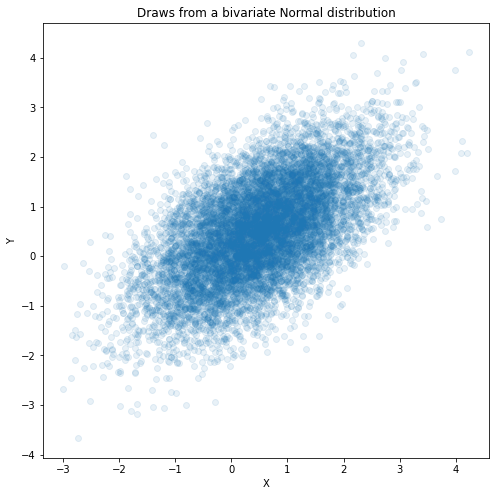

In [6]:
def plot_bi_variate(x, title='Draws from a bivariate Normal distribution'):
    ## Plot bi-variable points
    fig, ax = plt.subplots(figsize=(8,8)) 
    ax.scatter(x[:, 0], x[:, 1], alpha=.1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    _=ax.set_title(title)


## Define the covariance and mean of the bivariate Normal. 
sigma = np.array([[1, .6], [.6, 1]])
mu = np.array([.5, .5])
## Sample 10,000 realizations from the bivariate Normal
random_points = np.random.multivariate_normal(mean=mu, cov=sigma,  size=10000)

## Plot the result
plot_bi_variate(random_points)

This plot looks as expected. The density of the dots is proportional to the probability density. You can see the effect of the covariance structure in the elliptical shape of the cloud of points. 

As a next step, let's look at the density of the marginal distributions of the $X$ and $Y$ variables. The code in the cell below plots histogram and density plots of the marginals. Execute this code and examine the result. 

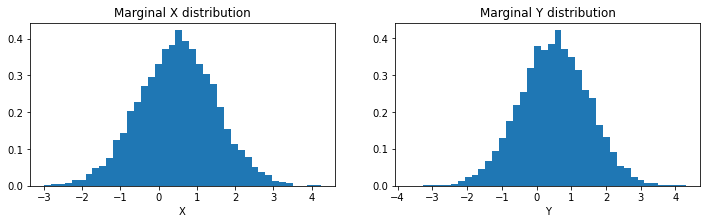

In [7]:
def plot_marginals(x):
    fig, ax = plt.subplots(1, 2, figsize=(12,3)) 
    ax[0].hist(x[:, 0], density=True, bins=40)
    ax[0].set_title('Marginal X distribution')
    ax[0].set_xlabel('X')
    ax[1].hist(x[:, 1], density=True, bins=40)
    ax[1].set_title('Marginal Y distribution')
    ax[1].set_xlabel('Y')  
    
plot_marginals(random_points)


> **Exercise 29-3:** Examine the plots above and answer the following questions:   
> 1. Do these marginal distributions appear approximately Normal? 
> 2. Do these marginal distributions exhibit any noticeable skewness or heavy tails? Is this behavior to be expected? 


Now, we are ready to sample these data using the M-H MCMC algorithm. The code in the cell below performs the following operations:

1. Compute the likelihood of the bi-variate Normal distribution. 
2. Initialize the chain.
3. Initialize some performance statistics.
4. Sample the likelihood of the data using the M-H algorithm.
5. Plot the result.

Execute this code and examine the result. 

(10000, 2)


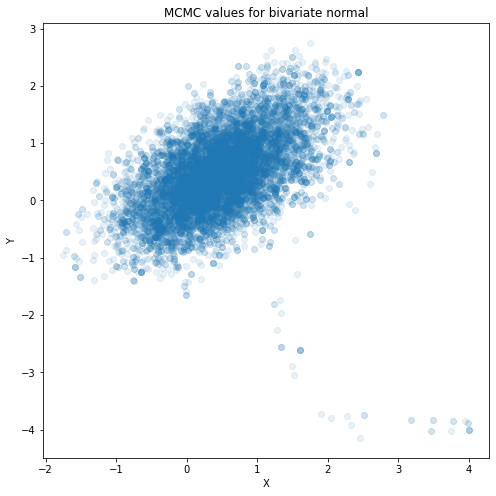

In [8]:
# Calculate the likelihood of a vector `x` for a multivariate normal
# distribution MVN(mu, sigma)
def likelihood(x, mu, sigma):
##    return ss.multivariate_normal.pdf(x, mu, sigma)
    return np.power(ss.multivariate_normal.pdf(x, mu, sigma),len(x))

# Initialize the output array
chain_length = 10000
chain = np.zeros((chain_length,2))
# where to start
chain[0,:] = [4.0,-4.0]


def M_H_sample(start, chain_length, x):
    ## Evaluate the current position
    current_likelihood = likelihood(start[0], mu, sigma)
    # Keep track of how often we accept or reject a proposal
    accept_count = 0
    reject_count = 0

    for i in range(chain_length-1): # chain length minus 1 because we already have a point (the starting point)
        # Sample the direction of the move we'll propose
        delta = nr.multivariate_normal([0, 0], np.diag([.1, .1]))
        # Our new proposal point is our previous position plus the sampled move
        proposed = chain[i,:] + delta
        proposed_likelihood = likelihood(proposed, mu, sigma)
        
        ## Accept according to probability 
        ## Two cases, are taken care of by one if statement since the uniform
        ## distribution is on the range [0-1], exceeding a random value is the 
        ## positive decision.  
        if (nr.uniform() < (proposed_likelihood / current_likelihood)):
            accept_count += 1
            current_likelihood = proposed_likelihood
            chain[i+1,:] = proposed
        else:
            chain[i+1,:] = chain[i,:]
            reject_count += 1 
    ## Return the result        
    return accept_count, reject_count, chain            

## Sample the data distribution
accept_count, reject_count, chain = M_H_sample(chain, chain_length, x=[0,0])
print(chain.shape)
## Plot the result
plot_bi_variate(chain, title='MCMC values for bivariate normal')


Notice the long 'tail' on the sampled distribution. This behavior arrises from the initial wandering of the Markov chain as it finds the high probability regions of the distribution. This period in which the Markov chain wanders is known as the **burn-in period**.


> **Exercise 29-4:** You will now investigate the properties of the MCMC burn-in period. As a first start, create a scatter plot of the X, Y variables for the first 5% of the Markov chain.   

In [9]:
## Add your code here



Examine you plot and answer these questions. 
1. How would you describe the reason for the 'trail' of samples from the initial sample value?  
2. What evidence do you see that the sampling is converging toward the actual distribution of these data values?   


> **Exercise 29-5:**  Next, you will plot the density of the marginal distribution of the MCMC samples beyond the 5% burn-in period. 

In [10]:
plot_marginals(chain[num_burnin:,:])

NameError: name 'num_burnin' is not defined

Compare your plots of the MCMC sample marginal distributions with the marginal distribution of the original data samples. Do the MCMC sample marginal distributions look reasonably similar to the marginal distributions of the original data samples?    


> **Exercise 29-6:** Next, you will compare the **Maximum a posteriori or MAP** point of the sampled marginal distributions to the original means for $X$ and $Y$. Using the [Numpy mean function](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) compute an approximation of the MAP for the MCMC sampled distribution. Compute and print this mean for i. the full chain, ii. the burn-in period and iii. the rest of the sample. 

Compare the results of your MAP estimates to the original data with $X = 0.5$ and $Y = 0.5$ and answer these questions. 
1. Does the MAP estimate, excluding the burn-in period, appear to be a reasonable estimate for the original data sample? 
2. Why does excluding the burn-in period from the MAP estimate improve it?

### Convergence and sampling efficiency of MCMC

Let's turn our attention to the convergence properties of the M-H MCMC sampler. While convergence of MCMC sampling to the underlying distribution generally occurs, it can be slow. Unfortunately, it is not unusual for convergence to be too slow to be of practical use. Further, in some pathological cases, convergence may not occur at all.  

The **acceptance rate** and **rejection rate** are key convergence statistics for the M-H algorithm. A low acceptance rate and high rejection rate are signs of poor convergence. Likewise, too few rejections, indicate that the algorithm is not exploring the parameter space sufficiently. The trade-off between these statistics is controlled by the dispersion of the sampling distribution. This hyperparameter is generally determined by trial and error. Unfortunately, there are few useful rules of thumb one can use.     

In [ ]:
print('Acceptance rate = %.2f' % (accept_count / chain_length))
print('Rejection rate = %.2f' % (reject_count / chain_length))

These statistics indicate good convergence with a reasonable rejection rate.

Another way to evaluate the convergence of MCMC algorithms is to look at the **trace** of the samples. The trace is a plot of the sample value with sample number. The code in the cell below plots the trace for both the $x$ and $y$ samples, including the burn-in period. Execute this code and examine the results. 

In [ ]:
def plot_traces(x):
    fig, ax = plt.subplots(2, 1, figsize=(12,6))
    ax[0].plot(x[:, 0])
    ax[0].set_title('X chain')
    ax[0].set_ylabel('Value')
    ax[1].plot(x[:, 1])
    ax[1].set_title('Y chain')
    ax[1].set_xlabel('Sample number')
    ax[1].set_ylabel('Value')

plot_traces(chain)

Examine these sample traces. The nature of these plots gives insight into the progression of the MCMC sampling. Notice that there is a significant excursion during the initial burn-in period. After the initial burn-in you can see that the sampling wanders around the mode of the distribution, as it should. 


> **Exercise 29-7:** You will now look at a close-up view of the traces just after the burn-in period. Create the code in the cell below to make plots of samples 1000 to 2000. Execute your code and examine the results. 

In [ ]:
## Put your code below


> Examine your plots and answer the following questions:   
> 1. Do the samples appear to be centered around the MAP in the densest part of the joint distribution, $P(X,Y)$? 
> 2. Do you consider the foregoing behavior ideal for the M-H algorithm, and why? 
> **End of exercise.**

Finally, let's take a look at the autocorrelation of our MCMC samples. Execute the code in the cell below, which uses the [Pandas.plotting.autocorrelation_plot](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.plotting.autocorrelation_plot.html) function to display the autocorrelation of each chain.   

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].set_title('Autocorrelation of X')
pd.plotting.autocorrelation_plot(chain[1000:2000, 0], ax=ax[0])
ax[0].set_title('Autocorrelation of Y')
pd.plotting.autocorrelation_plot(chain[1000:2000, 1], ax=ax[1])

Notice that the autocorrelation dies off fairly quickly with lag. We can relate sampling efficiency to the autocorrelation of the samples. Intuitively, uncorrelated samples provide maximum information on the distribution being sampled. But, if there is significant autocorrelation, the new information gathered per-sample will be reduced, perhaps greatly so.   

We can compute an **effective sample size or ESS**. ESS is the ratio between the number of samples adjusted for the autocorrelation and the hypothetical number of uncorrelated samples. In other words, the ratio of actual vs. ideal sampling. For a sample of size $N$, and autocorrelation function at lag k$, $ACF(k)$,we compute the ESS as follows:

$$ESS = \frac{N}{1 + 2 \sum_k ACF(k)}$$    

If the autocorrelation is low, the number of effective samples is high. However, if there is significant autocorrelation the ESS will be significantly less than the actual number of samples.

We will return to this concept with an example latter in this lesson.

## Other MCMC Sampling Algorithms

Now that you have some experience with the Metropolis-Hastings MCMC algorithm, let's examine some other MCMC sampling methods. The Metropolis-Hastings algorithm is a useful tool. However, this algorithm can suffer from slow convergence for several reasons:

- Samples from the M-H algorithm generally have a fairly high serial correlation, resulting in low ESS. 
- As already discussed, one must ‘tune’ the state selection probability distribution. For example, if we use a Normal sampling distribution we must pick $\sigma$. If $\sigma$ is too small, the chain will only search the space slowly, with small jumps. If $\sigma$ is too big, the the jumps are too large, slowing convergence.

As a result of these limimitations, quite a number of MCMC sampling methods have been proposed in a quest to improve sample efficiency. Here, we will only address a few widely used choices.   

### Gibbs sampling

The Gibbs sampler (Geman and Geman, 1984) is an improved MCMC sampler which speeds convergence. The Gibbs sampler is named for the 19th Century physicist Josiah Willard Gibbs and is inspired by statistical mechanics.   

In contrast to the M-H algorithm, the Gibbs sampler samples each dimension of the parameter space sequentially in a round-robin manner. Whereas, the M-H algorithm attempts jumps across all dimensions of the parameter space. 

The basic Gibbs sampler algorithm has the following steps:

1. For an N dimensional parameter space, $\{ \theta_1, \theta_2, \ldots, \theta_N \}$, find a random starting point. 
2. In order, $\{1, 2, 3, \ldots, N\}$, assign the next dimension to sample, starting with dimension $1$.  
3. Sample the marginal distribution of the parameter given the observations, $D$, and other parameter values: $p(\theta_1|D, \theta_2, \theta_3, \ldots, \theta_N)$.
3. Repeat steps 2 and 3 until convergence.    

From this simplified description of the Gibbs sampling algorithm you can infer.

- When compared to the Metropolis-Hastings algorithm, the Gibbs sampler reduces serial correlation through round-robin sampling. The update along each dimension is approximately orthogonal to the preceding sample dimensions.    
- There are no tuning parameters since sampling is based on the marginals of the likelihood.

### No U-Turn Sampler   

The PyMC3 package uses the No U-Turn Sampler (NUTS) MCMC algorithm. NUTS uses an alternative to proposing new samples with the Metropolis-Hastings acceptance criteria or exploring dimensions in a round-robin fashion as done for the Gibbs sampler. Instead, NUTS models the exploration as the movement of a particle through a field. In 2-dimensions, this field can be imagined to look like a hilly landscape. The high spots on the hills are the high density regions we want to sample the most. The field that guides the movement of the particle through the space is derived from the target probability distribution, such that the particle is drawn towards dense (high likelihood) regions of the space. This strategy directs the exploration of the space using the gradient, rather than using a random wandering behavior as we saw with the M-H MCMC algorithm.

The NUTS sampler is based on an earlier idea, Hamiltonian Monte Carlo. Imagine a ball in a 2-dimensional hilly landscape. The ball follows the gradient, which might send it part of the way up one of the hills. These hills represent the highest density regions of a distribution which we wish to sample. The difficulty with this idea is that the ball will often simply roll back down the hill to a less interesting low-density region. The original HMC method requires 2 hyperparameters to control stopping criteria of the ball. Unfortunately, in practice, setting these hyperparameters proved tricky, which limited the usefulness of HMC in practice.  

The NUTS sampler adds a simple heuristic to the HMC algorithm. Stop the ball from rolling, if it tries to turn around. In other words, the ball is prevented from making U-turns in the density space. The need for complex stopping criteria, and associated hyperparameters, is eliminated. As a result, NUTS is both a highly efficient sampler and easy to use. 

Why even discuss other samplers when we have the NUTS algorithm? Unfortunately, while NUTS works well in many common cases, it is not guaranteed to converge. For density functions with highly complex behavior, other samplers are required. In these cases, the Gibbs sampler is typically used.  

## Hierarchical modeling

So far, we have only worked with models having a simple flat parameter structure. To extend to more complex models and fully employ the power of Bayesian methods, we must use **hierarchical models**. These models allow us to compute posterior distributions, accounting for dependency in the parameters. 

### Chain rule of probability

As the name implies, hierarchical Bayesian models use a hierarchy of conditional probability distributions. Creating the required hierarchy employs the **chain rule of probability** to **factor a joint distribution**. Recall a basic relationship for conditional probability for the point distribution of two random variables, $A$ and $B$:  

$$P(A,B) = P(A|B)P(B)$$

We can expand this relationship to a joint distribution of $n$ random variables, $A_1, A_2, A_3, A_4 \ldots, A_n$:

$$P(A_1, A_2, A_3, A_4 \ldots, A_n) = P(A_1 | A_2, A_3, A_4, \ldots, A_n)\ P(A_2, A_3, A_4 \ldots, A_n)$$

In words, a joint distribution can be factored as a distribution of one of the variable, conditioned on the other variables, multiplied by the joint distribution of the other variables. 

We can continue this factorization until we reach an end point:

$$P(A_1, A_2, A_3, A_4 \ldots, A_n) = P(A_1 | A_2, A_3, A_4, \ldots, A_n)\ P(A_2 | A_3, A_4 \ldots, A_n)\ P(A_3| A_4 \ldots, A_n) \ldots P(A_n)$$

> **Note:** The factorization is not unique. We can factor the variables in any order. In fact, for a joint distribution with $n$ variables, there are $n!$ unique factorizations. For example, we can factorize the foregoing distribution as:

$$P(A_1, A_2, A_3, A_4 \ldots, A_n) = P(A_n | A_{n-1}, A_{n-2}, A_{n-3}, \ldots, A_1)\ P(A_{n-1}| A_{n-2}, A_{n-3}, \ldots, A_1)\ P(A_{n-2}| A_{n-3}, \ldots, A_1) \ldots p(A_1)$$     

### Factorization applied to hierarchical models   

We can apply the chain rule of probability to Bayes theorem. This approach allows us to create hierarchical Bayesian models. The hierarchy is determined by the factorization of the probability distribution used.     

To make the foregoing concrete, let's consider an example of a multi-parameter model; estimating both the mean, $\mu$, and standard deviation, $\sigma$, of a Normal distribution. For this two-parameter model, we can write Bayes theorem like this:

$$p(\mu, \sigma | D) \propto p(D| \mu, \sigma) p(\mu, \sigma)$$

This form looks a bit daunting since the likelihood and the prior both involved two parameters. Fortunately, we can simplify this relationship by applying the chain rule of probability: 

\begin{align}
p(\mu, \sigma | D) &\propto p(D | \mu) p(\mu | \sigma) p(\sigma)\\
&\propto\ Likelihood\ *\ Prior\ of\ \mu\ given\ \sigma\ *\ Prior\ of\ \sigma
\end{align}

As you can see, a complex multi-parameter Bayesian model is transformed into a hierarchy. The factorization has two likelihood functions, each with only a single parameter; the mean and the scale or variance. There are now two priors as well. One prior is a conditional distribution.    

### The Gamma distribution

For the prior of the standard deviation, we will be using the Gamma distribution. You may not be familiar with the [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution). We will give a brief introduction here.   

There are several ways one can parameterize the Gamma distribution. One method is to specify a shape parameter, $a$ and a scale parameter, $b$. The special case of $a=1$ is the exponential distribution.  

The Gamma distribution is defined on the range $0 > Gamma(a,b) > \infty$. This range is a desirable property for a prior, since scale parameters must have values $>0$.   

The code in the cell below displays the Gamma distribution for several values of the shape parameter, $a$, with fixed scale parameter, $b=2.0$. Execute this code and examine the result. 

In [ ]:
fig, ax = plt.subplots(1, 1)
a_list=[1.0,2.0,3.0,4.0]
x = np.linspace(ss.gamma.ppf(0.001, a_list[0]),
                ss.gamma.ppf(0.999, a_list[0]), 1000)
for a in a_list:
    ax.plot(x, ss.gamma.pdf(x, a, scale=2.0),
        lw=2, alpha=0.6, label='a = ' + str(a))
ax.set_title('Density of Gamma distribution')    
_=ax.legend()    

### Creating a MCMC hierarchical Bayes Model

Given the foregoing factorization of the posterior distribution, we will now define an **hierarchical Bayes model**. The model is considered hierarchical since the quantity we really want to know, the posterior distribution depends on the distribution of two model parameters. At first glance, it might seem some direct method of computing the posterior distribution can be easily found. But, this is not the case. Hence, we resort to finding an approximate solution using MCMC methods. 

The structure of the hierarchical model is shown in the figure below. The priors for the mean, $\mu$, and standard deviation, $\sigma$ are shown along with the Normal posterior.

<img src="../images/HierarchicalModel.png" alt="Drawing" style="width:550px; height:300px"/>
<center> Hierarchical model for the posterior distribution </center>

In mathematical terms we can define the hierarchical model as follows:
 
1. The prior of the scale, $\sigma$, is the Gamma distribution: $Gamma(2, 2)$. We choose this prior since it is fairly uninformative and we can imagine not having much prior information in this case.  
2. The prior distributions of the mean, $\mu$, is modeled as Normal distribution: $N(0, 3)$. The Normal is its own conjugate distribution. Further, this prior, with a large scale parameter, is fairly uninformative and will not restrict the posterior distribution values. 
3. The posterior distribution is defined using the priors for $\mu$ and $\sigma$ and the Normal likelihood.   
  
The code in the cell below creates a Normally distributed random sample. Execute the code and examine the histogram.  

In [ ]:
## Set up the data set as a regression problem
nr.seed(2233)
N = 1000
observations = nr.normal(loc=2.0, scale=2.0, size=N)

plt.hist(observations, bins=40)
_ = plt.title('Synthetic data for hierarchical Bayes problem')

Now that we have defined the structure of the model we will create the model in code using the PyMC3 package. The code in the cell below does so by the following steps:
1. A [PyMC3 model object](https://docs.pymc.io/api/model.html) is created. This object serves as a container for the model and the MCMC samples. 
2. The prior distributions of the scale, $\sigma$, and location, $\mu$ are defined. 
3. A model for the posterior distribution is defined.  

Execute the code to create the model object.

In [ ]:
def create_model(y):
    ## define a PyMC3 model object
    model = pymc3.Model()

    with model:
        # Define the prior distributions for the two model parameters, location, mu and scale
        scale = pymc3.Gamma('scale', alpha=2,beta=2)
        mu = pymc3.Normal('mu', mu=0, sigma=3.0)
        
        # The model for the posterior distribution uses the priors of the location and scale
        # to model the observations.   
        y_obs = pymc3.Normal('y_obs', mu=mu, sigma=scale, observed=y)
    return model

model = create_model(observations)

With the model defined, you can now compute the MCMC samples. Execute the code in the cell below to compute the [samples](https://docs.pymc.io/api/inference.html#module-pymc3.sampling) with PyMC3.

*******************
> **Computational note:** This example problem is fairly simple and the MCMC chains converge quickly. As a result only 1,000 samples per chain are required. For more complex problems, 10,000 or more samples per chain may be required. 

In [ ]:
## We will use 4 chains with 1000 samples each
num_chains = 4
Nsamples = 1000

## Compute the samples using the default NUTS sampler.   
with model:
    samples = pymc3.sample(Nsamples, chains=num_chains)
samples

The code in the cell below plots the posterior density estimates and traces for the 4 MCMC chains for each of the model parameters. Execute this code and examine the results. 

In [ ]:
## Plot the traces and the density estimates from the 4 MCMC chains
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    _ = pymc3.plots.traceplot(samples) 


> **Exercise 29-8:** Examine these plots and answer the following questions:
> 1. The trace plots on the right show the path of the 4 MCMC chains for the $a$ and $b$ model parameters. Do the traces of all 4 chains look similar in terms of convergence? 
> 2. The density for the $a$ and $b$ model parameters are shown on the left. Do these posterior distributions seem compatible with the known values of the distribution parameters used to generate the data? 

> **Answers:**   
> 1. 
> 2. 

### Evaluating the solution  

Now that the MCMC sampling of the model is complete, let's evaluate the results. PyMC3 provides quite a number of model evaluation statistics. These can be found in the [Stats section of the PyMC3 documentation](https://pymc3.readthedocs.io/en/latest/api/stats.html).   

As a first step, execute the code in the cell below to display a summary of the samples of the model. 

In [ ]:
pymc3.summary(samples)

The summary shows a lot of useful information:
    
1. The mean of the posterior distribution of each coefficient value. 
2. The standard deviation (`sd`) of the mean of the posterior distribution of the coefficient values. 
3. The upper and lower bonds of the 96% **Highest Probability Density (HPD)** interval estimate for the posterior distribution of the coefficients. HPD is an alternative term for the Highest Density Interval (HDI) or the credible interval.  
4. The msce_mean is an estimate of the error arising from the MCMC sampling itself. The msce_sd is standard deviation of this mean. Ideally, these quantities should be small with respect to the mean value of the posterior distribution. The MCMC sampling should add only minimal noise to the posterior distribution.  
5. Next come four metrics of **effective sample size (ESS)**. We have already discussed the concept of effective sample size. These metrics give indications of overall ESS alone with specific metrics for the bunk of the posterior distribution and its tails. These statistics are reported with respect to the total number of samples in all chains.    
6. The **Gelman-Rudin statistic** (`Rhat`) (Gelman and Rubin, 1992) measures the ratio of the **variance shrinkage between chains** to the **variance shrinkage within chains**. The Gelman-Rudin statistic should converge to 1.0. That is, if all chains converge, the reduction in variance between chains and within the chains should be the same.  

> **Exercise 29-9:** Given the statistics for the MCMC samples and the foregoing explanation answer the following questions:   
> 1. Given the HPD and standard deviation how credible are the estimates of the means of the posterior distributions of the coefficients?   
> 2. Given the ESS statistics how efficient does the MCMC samples appear to be?   
> 3. Given the Gelman-Rudin statistic, does it appear that the Monte Carlo chains have converged?     

Next, we will examine the HDI (or HPD) of the parameter estimates for each of the Markov chains for each of the parameters. We will examine this in two ways. First, the evolution of the interval with sampling. Second, by aggregated over the sampling history.      

The code in the ell below creates plots of the mean of the posterior distribution and the HDI for each parameter during the evolution of each Monte Carlo chain. Execute the code and examine the results.     

In [ ]:
def trace_variable(samples, varnames, quantiles=(0.025, 0.5, 0.975)):
    for i, chain in enumerate(samples.chains):
        for j, varname in enumerate(varnames):
            plt.subplot(len(samples.chains), len(varnames), i * len(varnames) + j + 1)
            values = pd.Series(samples.get_values(varname, chains=chain))
            for q in quantiles:
                plt.plot(
                    values.expanding(min_periods=1).quantile(q), 
                    label='%.3f' % q)
            plt.title('var=%s, chain=%d' % (varname, chain))
            plt.legend(loc='upper right')
    plt.tight_layout()


plt.figure(figsize=(8, 12))
trace_variable(samples, ['mu', 'scale'])

To gain another view of the posterior distribution and the HDI, execute the code in the cell below to display range plots for each Markov chain and for each variable.  

In [ ]:
_=pymc3.forestplot(samples)

> **Exercise 29-10:** 
> Examine the results in the plots and answer the following questions:    
> 1. Do the Monte Carlo chains appear to converge quickly?   
> 2. Are the HDIs consistent across the Monte Carlo chains?   
> 3. Are the known parameters used to generate the data within the HDI of the Monte Carlo chains?  

As we already discussed, the convergence of MCMC algorithms is slowed by **autocorrelation** between the samples. PyMC3 provides the `autocorrplot()` function for examining the autocorrelation in Markov chains. The function creates autocorrelation function plots for each parameter and chain combination. 

To examine the results for the Markov chains, execute the code in the cell below. 

In [ ]:
_ = pymc3.autocorrplot(samples, max_lag=25, figsize=(10, 4))

Examine these plots and notice the low autocorrelations. These are unusually low, since the problem was particularly simple and the parameters easy to estimate.  

## Summary

In this lesson you have done the following:

- Reviewed the basic properties of a Markov process and Markov chains.
- Performed a simple Markov chain Monte Carlo using the Metropolis-Hastings algorithm.
- Created and computed a hierarchical Bayes model using No U-Turn Sampling in the PyMC3 package.
- Evaluated the convergence of the model. 

#### Copyright 2017, 2018, 2019, 2020, 2021 Stephen F Elston. All rights reserved.

Rights to use and modify this material on an unlimited and perpetual basis are granted to the University of Washington for use only by the University of Washington.  